In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import re
import string
import gensim
from gensim.models import FastText
import random
from tabulate import tabulate
from tqdm import tqdm
import tensorflow as tf

In [4]:
import nltk
import subprocess
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('punkt', download_dir='/kaggle/working/')
    nltk.download('wordnet', download_dir='/kaggle/working/')
    nltk.download('stopwords', download_dir='/kaggle/working/')
    nltk.download('wordnet', download_dir='/kaggle/working/')
    nltk.download('averaged_perceptron_tagger', download_dir='/kaggle/working/')

    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /kaggle/working/...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
train = pd.read_csv('/content/drive/MyDrive/NIT/train.csv')
test = pd.read_csv('/content/drive/MyDrive/NIT/test.csv')

In [6]:
train_data = train[:10000]
test_data = test[:2000]

In [7]:
df = pd.concat([train_data,test_data], ignore_index=True, sort =False)

In [8]:
df.head(10)

,label,tweet
0,1,"@ApostleDavid yeah, i would agree with that."
1,0,The FAA intentions to up pilot safety and trai...
2,1,Think it's time for an early night. 1 or 2 eps...
3,1,@RavenousReadr Chicken. I don't eat much steak.
4,1,Woohoo! Faith No More to play Dublin in August...
5,1,http://tinyurl.com/m9m95f -&gt; Use Windows Mo...
6,0,Crazy cat...man? guy? dude? Is that what i've ...
7,0,craving bbq. Too bad we dont' have a bbq
8,0,has a busy week ahead and is already so tired
9,1,@justiniiams Back home in Weaverville.


In [9]:
# Define a dictionary to map sentiment values
# sentiment_mapping = {0: "Negative", 1: "Positive"}



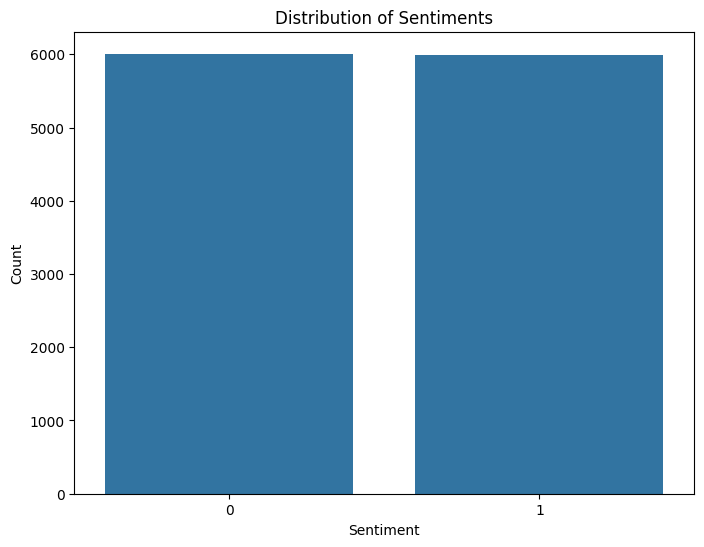

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sentiment_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [11]:
def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

def remove_links(text):
    return re.sub(r'http\S+', '', text)

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

def normalize_tokens(tokens):
    normalized_tokens = [token.lower() for token in tokens]
    return normalized_tokens

def clean_tokens(tokens):
    cleaned_tokens = [token for token in tokens if token.isalnum() and not token.isdigit() and not token.startswith('@')]
    return cleaned_tokens

def remove_stopwords(tokens):

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        pos_tag = nltk.pos_tag([token])[0][1][0].upper()
        pos_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
        wordnet_pos = pos_map.get(pos_tag, wordnet.NOUN)
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmatized_tokens.append(lemma)
    return lemmatized_tokens

def filter_meaningful_tokens(tokens):
    meaningful_tokens = [token for token in tokens if len(token) >= 3]
    return meaningful_tokens

def preprocess_text(text):
    text = remove_usernames(text)
    text = remove_links(text)
    tokens = tokenize_text(text)
    normalized_tokens = normalize_tokens(tokens)
    cleaned_tokens = clean_tokens(normalized_tokens)
    filtered_tokens = remove_stopwords(cleaned_tokens)
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)
    meaningful_tokens = filter_meaningful_tokens(lemmatized_tokens)
    preprocessed_text = ' '.join(meaningful_tokens)

    return preprocessed_text

In [12]:
# Apply preprocessing function to 'text' column of the DataFrame
df['cleaned_text'] = df['tweet'].apply(preprocess_text)

# Display the DataFrame with cleaned text
# df.head(10)

In [13]:
df.head(50)

,label,tweet,cleaned_text
0,1,"@ApostleDavid yeah, i would agree with that.",yeah would agree
1,0,The FAA intentions to up pilot safety and trai...,faa intention pilot safety training well recie...
2,1,Think it's time for an early night. 1 or 2 eps...,think time early night eps family guy bed
3,1,@RavenousReadr Chicken. I don't eat much steak.,chicken eat much steak
4,1,Woohoo! Faith No More to play Dublin in August...,woohoo faith play dublin august excellent feel...
5,1,http://tinyurl.com/m9m95f -&gt; Use Windows Mo...,use window mobile phone pay
6,0,Crazy cat...man? guy? dude? Is that what i've ...,crazy cat man guy dude turn
7,0,craving bbq. Too bad we dont' have a bbq,crave bbq bad dont bbq
8,0,has a busy week ahead and is already so tired,busy week ahead already tire
9,1,@justiniiams Back home in Weaverville.,back home weaverville


In [14]:

df.tail(50)

,label,tweet,cleaned_text
11950,1,@Alyalz hey i love burning up book tour too,hey love burning book tour
11951,1,"@AngryBritain o milord u came back, miss u loa...",milord come back miss load much luv devote gro...
11952,1,Well... Diversity won Britains Got Talent..bet...,well diversity britain get talent bet burst su...
11953,1,@sachar Hey mr! On twitter again!? How's life...,hey twitter life flipside
11954,0,@elainanic awww,awww
11955,1,just got the TV fixed up in the room!!,get fix room
11956,0,OK I mean it can not display chinese in its in...,mean display chinese input box
11957,0,Why must Sydney real estate be so bloody expen...,must sydney real estate bloody expensive like ...
11958,1,im still on a high from yesterday,still high yesterday
11959,0,@mizzmadpie we have five days left,five day left


In [15]:
df.shape

(12000, 3)

In [16]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X = df['cleaned_text']
y = df['label']

# Splitting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert sentiment labels to numerical format
# y_train_numeric = (y_train == 'Positive').astype(int)
# y_test_numeric = (y_test == 'Positive').astype(int)

# Displaying the shapes of the new DataFrames
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (9600,)
Testing data shape: (2400,)


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score # Import necessary metrics
import gensim.downloader as api  # Import gensim downloader

# Assuming `tokenized_tweet` and `y` are already defined
# tokenized_tweet is a list of tokenized tweets or text data
# y is the corresponding target labels

# Download a pre-trained Word2Vec model (this might take a while)
model_w2v = api.load('word2vec-google-news-300')  # Load a pre-trained model

# Splitting the data into features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], y, test_size=0.2, random_state=42)

# Function to average Word2Vec embeddings for a sentence
def get_avg_word2vec(tokens_list, vector, generate_missing=False, k=300): # Adjust k to match model dimension
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        # Access vectors directly through model_w2v
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        # Access vectors directly through model_w2v
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# Apply Word2Vec embeddings to training and testing data
# Access vectors directly through model_w2v
X_train_w2v = np.array([get_avg_word2vec(tokens, model_w2v) for tokens in X_train])
# Access vectors directly through model_w2v
X_test_w2v = np.array([get_avg_word2vec(tokens, model_w2v) for tokens in X_test])

# Create a validation set - adjust test_size as needed
X_train_w2v, X_valid_w2v, y_train, y_valid = train_test_split(X_train_w2v, y_train, test_size=0.2, random_state=42) # Creating a validation set

# Print shapes to verify
print("Training data shape (Word2Vec):", X_train_w2v.shape)
print("Testing data shape (Word2Vec):", X_test_w2v.shape)
print("Validation data shape (Word2Vec):", X_valid_w2v.shape) # Added validation set shape



[==================================================] 100.0% 1662.8/1662.8MB downloaded
Training data shape (Word2Vec): (7680, 300)
Testing data shape (Word2Vec): (2400, 300)
Validation data shape (Word2Vec): (1920, 300)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr_w2v = LogisticRegression()
lr_w2v.fit(X_train_w2v, y_train)
predictions = lr_w2v.predict(X_valid_w2v)
print("Accuracy score for Word2Vec Logistic Regression model:", accuracy_score(y_valid, predictions))
print("Classification report for Word2Vec Logistic Regression model:")
print(classification_report(y_valid, predictions))

Accuracy score for Word2Vec Logistic Regression model: 0.5614583333333333
Classification report for Word2Vec Logistic Regression model:
              precision    recall  f1-score   support

           0       0.56      0.55      0.56       962
           1       0.56      0.57      0.57       958

    accuracy                           0.56      1920
   macro avg       0.56      0.56      0.56      1920
weighted avg       0.56      0.56      0.56      1920



In [23]:
from sklearn.naive_bayes import GaussianNB  # Import Gaussian Naive Bayes
from sklearn.metrics import accuracy_score, classification_report

# Train Gaussian Naive Bayes classifier (suitable for continuous data)
nb_w2v = GaussianNB()  # Change to GaussianNB
nb_w2v.fit(X_train_w2v, y_train)

# Predict on test data
y_pred_w2v_nb = nb_w2v.predict(X_test_w2v)

In [21]:
# Initialize SVM classifier
svm_w2v = SVC(kernel='linear', random_state=42)

# Fit SVM classifier on Word2Vec embeddings
svm_w2v.fit(X_train_w2v, y_train)

# Predictions on the test set
y_pred_svm_w2v = svm_w2v.predict(X_test_w2v)

# Evaluate SVM classifier with Word2Vec embeddings
accuracy_svm_w2v = accuracy_score(y_test, y_pred_svm_w2v)
print("SVM Classifier with Word2Vec Accuracy:", accuracy_svm_w2v)
print("SVM Classifier with Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_svm_w2v))


SVM Classifier with Word2Vec Accuracy: 0.5554166666666667
SVM Classifier with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      1219
           1       0.55      0.57      0.56      1181

    accuracy                           0.56      2400
   macro avg       0.56      0.56      0.56      2400
weighted avg       0.56      0.56      0.56      2400



In [24]:
# Initialize Random Forest classifier
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit Random Forest classifier on Word2Vec embeddings
rf_w2v.fit(X_train_w2v, y_train)

# Predictions on the test set
y_pred_rf_w2v = rf_w2v.predict(X_test_w2v)

# Evaluate Random Forest classifier with Word2Vec embeddings
accuracy_rf_w2v = accuracy_score(y_test, y_pred_rf_w2v)
print("Random Forest Classifier with Word2Vec Accuracy:", accuracy_rf_w2v)
print("Random Forest Classifier with Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_rf_w2v))


Random Forest Classifier with Word2Vec Accuracy: 0.5525
Random Forest Classifier with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58      1219
           1       0.55      0.51      0.53      1181

    accuracy                           0.55      2400
   macro avg       0.55      0.55      0.55      2400
weighted avg       0.55      0.55      0.55      2400



In [25]:
# Initialize Decision Tree classifier
dt_w2v = DecisionTreeClassifier(random_state=42)

# Fit Decision Tree classifier on Word2Vec embeddings
dt_w2v.fit(X_train_w2v, y_train)

# Predictions on the test set
y_pred_dt_w2v = dt_w2v.predict(X_test_w2v)

# Evaluate Decision Tree classifier with Word2Vec embeddings
accuracy_dt_w2v = accuracy_score(y_test, y_pred_dt_w2v)
print("Decision Tree Classifier with Word2Vec Accuracy:", accuracy_dt_w2v)
print("Decision Tree Classifier with Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_dt_w2v))


Decision Tree Classifier with Word2Vec Accuracy: 0.53625
Decision Tree Classifier with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      1219
           1       0.53      0.54      0.53      1181

    accuracy                           0.54      2400
   macro avg       0.54      0.54      0.54      2400
weighted avg       0.54      0.54      0.54      2400



In [26]:
predictions = lr_w2v.predict(X_valid_w2v)
print("Accuracy score for Word2Vec Logistic Regression model:", accuracy_score(y_valid, predictions))
print("logistric regression with word2vec Classification Report:")
print(classification_report(y_valid, predictions))


# Evaluate Decision Tree classifier with word2vec
accuracy_dt_w2v = accuracy_score(y_test, y_pred_dt_w2v)
print("Decision Tree Classifier with word2vec Accuracy:", accuracy_dt_w2v)
print("Decision Tree Classifier with word2vec Classification Report:")
print(classification_report(y_test,y_pred_dt_w2v))


# Evaluate SVM classifier with word2vec
accuracy_svm_w2v = accuracy_score(y_test, y_pred_svm_w2v)
print("SVM Classifier with word2vec Accuracy:", accuracy_svm_w2v)
print("SVM Classifier with word2vec Classification Report:")
print(classification_report(y_test, y_pred_svm_w2v))


# Evaluate Random Forest classifier with word2vec
accuracy_rf_w2v = accuracy_score(y_test, y_pred_rf_w2v)
print("Random Forest Classifier with word2vec Accuracy:", accuracy_rf_w2v)
print("Random Forest Classifier with word2vec Classification Report:")
print(classification_report(y_test, y_pred_rf_w2v))


# Evaluate accuracy
accuracy_w2v_nb = accuracy_score(y_test, y_pred_w2v_nb)
print("word2vec Multinomial Naive Bayes Accuracy:", accuracy_w2v_nb)
print("Decision Tree Classifier with word2vec Classification Report:")
print(classification_report(y_test, y_pred_w2v_nb))

Accuracy score for Word2Vec Logistic Regression model: 0.5614583333333333
logistric regression with word2vec Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.56       962
           1       0.56      0.57      0.57       958

    accuracy                           0.56      1920
   macro avg       0.56      0.56      0.56      1920
weighted avg       0.56      0.56      0.56      1920

Decision Tree Classifier with word2vec Accuracy: 0.53625
Decision Tree Classifier with word2vec Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      1219
           1       0.53      0.54      0.53      1181

    accuracy                           0.54      2400
   macro avg       0.54      0.54      0.54      2400
weighted avg       0.54      0.54      0.54      2400

SVM Classifier with word2vec Accuracy: 0.5554166666666667
SVM Classifier with word2vec Classifi